Text Classification using Attention Bi-LSTM implemented with
1. torchtext
2. dataset & dataloader

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install transformers

     |████████████████████████████████| 2.0MB 6.9MB/s 
     |████████████████████████████████| 890kB 33.1MB/s 
     |████████████████████████████████| 3.2MB 48.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=474cd93f1d144ae8312897843e4785d69aec2befbc19036af2520ae98faaabb9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
import pickle
import time 
from gensim.models import Word2Vec

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

from torchtext.legacy import data, datasets, vocab
#from torchtext import data, datasets, vocab
from torchtext.vocab import GloVe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
#print("GPU Available: {}".format(torch.cuda.is_available()))
if torch.cuda.is_available() == True:
    device = 'cuda'
    n_gpu = torch.cuda.device_count()
    print("Number of GPU Available: {}".format(n_gpu))
    print("GPU: {}".format(torch.cuda.get_device_name(0)))
else:
    device = 'cpu'
    print("Running on CPU")

Number of GPU Available: 1
GPU: Tesla T4


In [5]:
# Reproducing same results
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  

# Torchtext

IMBD dataset
- Binary Classification

In [6]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths=True)
LABEL = data.LabelField()

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [7]:
BATCH_SIZE=64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
NUM_LABELS = 1
HIDDEN_DIM = 200
EMB_DIM = 200
#DROPOUT = 0.

In [8]:
TEXT.build_vocab(train_data, vectors='glove.6B.200d')
LABEL.build_vocab(train_data)

VOCAB_SIZE = len(TEXT.vocab)
vec = TEXT.vocab.vectors
print(VOCAB_SIZE)
print(vec.shape)

101520
torch.Size([101520, 200])


In [9]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(5))  

#Word dictionary
print(TEXT.vocab.stoi)  

Size of TEXT vocabulary: 101520
Size of LABEL vocabulary: 2
[('the', 328822), (',', 275296), ('.', 236843), ('and', 162887), ('a', 161730)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f2c5d338850>>, {'<unk>': 0, '<pad>': 1, 'the': 2, ',': 3, '.': 4, 'and': 5, 'a': 6, 'of': 7, 'to': 8, 'is': 9, 'it': 10, 'in': 11, 'i': 12, 'this': 13, 'that': 14, '"': 15, "'s": 16, '-': 17, '/><br': 18, 'was': 19, 'as': 20, 'for': 21, 'with': 22, 'movie': 23, 'but': 24, 'film': 25, 'on': 26, 'you': 27, '(': 28, ')': 29, "n't": 30, 'not': 31, 'are': 32, 'he': 33, 'his': 34, 'have': 35, 'be': 36, 'one': 37, 'all': 38, 'at': 39, 'they': 40, 'by': 41, '!': 42, 'an': 43, 'who': 44, 'from': 45, 'like': 46, 'so': 47, 'her': 48, 'or': 49, 'there': 50, 'just': 51, 'about': 52, 'do': 53, "'": 54, 'has': 55, 'out': 56, 'if': 57, 'what': 58, 'some': 59, 'good': 60, '?': 61, 'she': 62, 'more': 63, 'very': 64, 'when': 65, 'would': 66, 'up': 67, 'no': 68, 'even': 69, 'time

In [10]:
# define Iterator
train_iter, test_iter = data.BucketIterator.splits(
        (train_data, test_data), sort_key=lambda x:len(x.text),
        sort_within_batch=True,
        batch_size=BATCH_SIZE, device=device,
        repeat=False)


In [11]:
# view batch in iterator 
for batch in train_iter:

  text, text_lengths = batch.text 

  print(text.size())
  print(text_lengths.size())

  print(text[0])
  print(text_lengths[0])
  break

torch.Size([204, 64])
torch.Size([64])
tensor([  536,  1755,    27,    50,    20,    15,    13,   132,   266,    12,
            6,     6,  2524,    72,    13,    24,    13,    12,    20,    15,
          531,    13,    12,    13,    13,    10,   300,    12,    12,    12,
           13,    12,   462,    40,    13,  2867,    11,     2, 31905,    13,
            2,   174,  1035,   284,    11,   277,    13, 20874,    58,    12,
          300,  8419,    13,   536,    13,    13,    72,    12,    13,    12,
         7844,    15,    13,    15], device='cuda:0')
tensor(204, device='cuda:0')


Model Architect

In [12]:
# helper functions

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    # b_ix = 1    

    model.train()

    for batch in tqdm(iterator):

        optimizer.zero_grad()
        
        text, text_lengths = batch.text 
        outputs, _ = model(text, text_lengths)

        loss = criterion(outputs.view(-1), batch.label.float())
        acc = binary_accuracy(outputs.view(-1), batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # if b_ix % 100 == 0:
        #     print('current loss:{:.4f}'.format(epoch_loss / b_ix))
        #     print('current acc:{:.4f}'.format(epoch_acc / b_ix))
        # b_ix += 1

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()

    with torch.no_grad():
        
        for batch in iterator:
            
            text, text_lengths = batch.text
            outputs, _ = model(text, text_lengths)

            loss = criterion(outputs.view(-1), batch.label.float())
            acc = binary_accuracy(outputs.view(-1), batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [19]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
      """hidden_dim is the emb_dim"""
      super().__init__()
      self.hidden_dim = hidden_dim
      self.projection = nn.Sequential(
              nn.Linear(hidden_dim, 64),
              nn.ReLU(True),
              nn.Linear(64, 1)
      )

    def forward(self, encoder_outputs):
            batch_size = encoder_outputs.size(0)
            # (B, L, H) -> (B , L, 1)
            energy = self.projection(encoder_outputs)
            weights = F.softmax(energy.squeeze(-1), dim=1)
            # (B, L, H) * (B, L, 1) -> (B, H)
            outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
            return outputs, weights

class att_bilstm(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim, hidden_dim, pretrained_emb=None): #, dropout=0.):
        super(att_bilstm, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        #self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, num_labels)
        
        self.attention = SelfAttention(hidden_dim)
        
        self.word_embeds = nn.Embedding(vocab_size, emb_dim)
        if pretrained_emb is not None:
            self.word_embeds.from_pretrained(torch.tensor(pretrained_emb,dtype=torch.float32),freeze=True)
    
    def forward(self, sequence, text_lengths):

        batch_size = sequence.size(1)
        emb_input = self.word_embeds(sequence) 
        #emb_input = self.dropout(emb_input)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(emb_input, text_lengths.cpu())
        out, (hn, cn) = self.lstm(packed_embedded)
        out = nn.utils.rnn.pad_packed_sequence(out)[0]
        out = out[:, :, :self.hidden_dim] + out[:, :, self.hidden_dim:] #sum bidir outputs F+B 
        embedding, attn_weights = self.attention(out.transpose(0, 1)) 
        outputs = self.fc(embedding.view(batch_size, -1))        
        return outputs, attn_weights
    

In [14]:
# Init remaining params
VOCAB_SIZE = len(TEXT.vocab)

In [20]:
model = att_bilstm(vocab_size=VOCAB_SIZE, num_labels=NUM_LABELS, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM, pretrained_emb=vec) #, dropout=DROPOUT)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)
print(model)

att_bilstm(
  (lstm): LSTM(200, 200, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=200, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (word_embeds): Embedding(101520, 200)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [16]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,960,330 trainable parameters


In [22]:
epochs=5
best_valid_loss = float('inf')

for epoch in range(epochs):

  train_loss, train_acc =  train(model, train_iter, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, test_iter, criterion)

  #save the best model
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), '/content/drive/My Drive/colab_data/attnbilstm/saved_weights.pt')
      print(f'\tModel Saved')
  
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  print()
  

print("Training Completed!")


	Model Saved
	Train Loss: 0.341 | Train Acc: 85.36%
	 Val. Loss: 0.283 |  Val. Acc: 88.36%




	Train Loss: 0.192 | Train Acc: 92.65%
	 Val. Loss: 0.285 |  Val. Acc: 88.83%




	Train Loss: 0.093 | Train Acc: 96.74%
	 Val. Loss: 0.318 |  Val. Acc: 88.97%




	Train Loss: 0.040 | Train Acc: 98.72%
	 Val. Loss: 0.433 |  Val. Acc: 88.58%




	Train Loss: 0.020 | Train Acc: 99.40%
	 Val. Loss: 0.549 |  Val. Acc: 87.83%

Training Completed!


In [31]:
#load weights
path='/content/drive/My Drive/colab_data/attnbilstm/saved_weights.pt'

model.load_state_dict(torch.load(path));
model.to(device);
model.eval();

import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1)                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                  #convert to tensor
    
    #print(tensor.size(), length_tensor.size())
    #print(tensor, length_tensor)
    prediction, _ = model(tensor, length_tensor)                  #prediction 
    prediction = torch.round(torch.sigmoid(prediction))
    return prediction  

In [32]:
# Make predictions {0:'negative', 1:'positive'}
print(predict(model, "This movie is so bad, it kinda sucks!")) # negative

print(predict(model, "The actor in the movie is good looking!")) # positive

tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward>)
tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward>)


# Dataset & DataLoader

Drugs Review Dataset
- Multiclass Classification

In [6]:
input_excel_file_path_train = "/content/drive/My Drive/colab_data/drugsComTrain_raw.csv"
input_excel_file_path_test = "/content/drive/My Drive/colab_data/drugsComTest_raw.csv"

train_df = pd.read_csv(input_excel_file_path_train, usecols=['condition','review'])
test_df = pd.read_csv(input_excel_file_path_test, usecols=['condition','review'])

print("train size: ", train_df.shape)
print("test size: ", test_df.shape)

train size:  (161297, 2)
test size:  (53766, 2)


In [7]:
count_df = train_df[['condition','review']].groupby('condition').count().reset_index()
print("Total no. of reviews in top 10 condition: ",count_df.sort_values('review', ascending=False).head(10)['review'].sum())
count_df.sort_values('review', ascending=False).head(10)

Total no. of reviews in top 10 condition:  73951


,condition,review
165,Birth Control,28788
262,Depression,9069
594,Pain,6145
125,Anxiety,5904
80,Acne,5588
164,Bipolar Disorde,4224
441,Insomnia,3673
839,Weight Loss,3609
563,Obesity,3568
73,ADHD,3383


In [8]:
# only taking subset of dataset; top 10 condition classification
top_10_conditions = count_df.sort_values('review', ascending=False).head(10)['condition'].tolist()
top_10_conditions

['Birth Control',
 'Depression',
 'Pain',
 'Anxiety',
 'Acne',
 'Bipolar Disorde',
 'Insomnia',
 'Weight Loss',
 'Obesity',
 'ADHD']

In [9]:
# Take rows where condition in top_10 list
train_df = train_df[train_df["condition"].isin(top_10_conditions)]
test_df = test_df[test_df["condition"].isin(top_10_conditions)]

print("train size: ", train_df.shape)
print("test size: ", test_df.shape)

train size:  (73951, 2)
test size:  (24772, 2)


In [14]:
label_dict = {}
for i, s in enumerate(top_10_conditions):
  label_dict.update({s: i})

print(label_dict)

{'Birth Control': 0, 'Depression': 1, 'Pain': 2, 'Anxiety': 3, 'Acne': 4, 'Bipolar Disorde': 5, 'Insomnia': 6, 'Weight Loss': 7, 'Obesity': 8, 'ADHD': 9}


In [10]:
def review_clean(review): 
    
    lower = review.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    series = multiw_remove.replace(r'\.{2,}', ' ')
    
    return series

In [11]:
train_df['review'] = train_df['review'].apply(lambda x: review_clean(x))
test_df['review'] = test_df['review'].apply(lambda x: review_clean(x))

In [12]:
train_df, valid_df = train_test_split(train_df, test_size=0.2)

print("train size: ", train_df.shape)
print("valid size: ", valid_df.shape)
print("test size: ", test_df.shape)

train size:  (59160, 2)
valid size:  (14791, 2)
test size:  (24772, 2)


In [15]:
# sample view
print("label id: ", label_dict[test_df['condition'].iloc[17]])
print("review: ", test_df['review'].iloc[17])

label id:  5
review:  "i started taking gabapentin experimentally to treat chronic depression and am now prescribed 1800mg a day.  at doses of 2700mg i experienced a significant improvement in impulse control and depression in general.  went from being a shut in, to going for walks and enjoying my time in the company of others.  at the lower dose of 1800mg a day, i dont experience much improvement, save for a decrease in depressive symptoms.  im looking forward to a larger dose if my doctor okays it."


In [16]:
# EDA: TEXT
max_len=0
length_list = []
for sent in train_df['review'].tolist():
    max_len = max(max_len, len(word_tokenize(sent)))
    length_list.append(len(sent))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', int(np.average(length_list)))

Max sentence length:  829
Avg sentence length:  481


In [17]:
input_excel_file_path_test = "/content/drive/My Drive/colab_data/drugsComTest_raw.csv"
df = pd.read_csv(input_excel_file_path_train, usecols=['condition','review'])

vocab_path = "/content/drive/My Drive/colab_data/attnbilstm/drugs_word2idx.pkl"

In [ ]:
# create vocab (word2idx)

#def vocab_build(df,vocab_path):
all_tokens = []
words = list(set(df["review"].values))

tokenize_words = df["review"].apply(lambda x: word_tokenize(x))
tokenize_words_list = tokenize_words.tolist()

all_tokens = []
for s in tokenize_words_list:
    all_tokens += s

print("No. of words: {}".format(len(all_tokens)))
print("No. of unique words: {}".format(len(set(all_tokens))))

unique_tokens = list(set(all_tokens))
word2idx = {w: i + 2 for i, w in enumerate(unique_tokens)}
word2idx["UNK"] = 1 
word2idx["PAD"] = 0 
#idx2word = {i: w for w, i in word2idx.items()}

with open(vocab_path, 'wb') as fw:
    pickle.dump(word2idx, fw)


No. of words: 16911721
No. of unique words: 93485


In [ ]:
# train word2vec embedding
start_time = time.time()    

w2v_model = Word2Vec(tokenize_words_list, 
                 min_count=2,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=3,      # Context window for words during training
                 iter=10)      

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

# save word embedding model
w2v_model.wv.save_word2vec_format('/content/drive/My Drive/colab_data/attnbilstm/drugs_attbilstm_w2v_200d.txt')

Time taken : 4.01 mins


In [19]:
def read_dictionary(vocab_path):
    
    with open(vocab_path, 'rb') as fr:
        word2idx = pickle.load(fr)
    print('vocab_size:', len(word2idx))
    
    return word2idx
    
def create_emb_matrix(vocab, emb_path, EMBEDDING_DIM=200):
    embedding_index = {}
    f = open(emb_path)

    print('Loading Embedding...')
    for line in f:
        values = line.split()
        word = values[0]
        embedding_index[word] = np.asarray(values[1:], dtype='float32')
    f.close()
    print('Done. Proceeding to load embedding matrix...', end='')

    embedding_matrix = np.zeros([len(vocab)+1,EMBEDDING_DIM])
    
    oov_count = 0
    rand_vect = None
    
    for word, i in vocab.items(): 
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = np.array(embedding_vector,dtype='float32')
        else:
            if rand_vect is None:
                rand_vect =  np.random.uniform(-1,1)
            embedding_matrix[i] = np.array(rand_vect,dtype='float32')
            oov_count += 1
    
    print('\nCompleted!')
    print('No. of oov words: ', oov_count)
    return embedding_matrix

In [20]:
#vocab_path = "/content/drive/My Drive/colab_data/attnbilstm/drugs_word2idx.pkl"

# if os.path.exists(vocab_path):
#     print("Loading word2idx...") 
# else:
#     print("Building word2idx..") 
#     vocab_path_ = os.path.join(vocab_path)
#     vocab_build(df,vocab_path)

word2idx = read_dictionary(vocab_path)

vocab_size: 93486


In [21]:
class CustomDataset(Dataset):
    def __init__(self, df, word2idx):
        self.data = df
        self.text = self.data['review']
        self.label = self.data['condition']
        
        self.word2idx = word2idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
            
        sample_input = self.text.iloc[index]
        sample_label = self.label.iloc[index]
        
        inputs_ = word_tokenize(sample_input.lower())
        inputs_ = [self.word2idx[w] if w in self.word2idx else self.word2idx['UNK'] for w in inputs_]
        #inputs_len = len(inputs_)
        
        label = {'Birth Control': 0, 'Depression': 1, 'Pain': 2, 'Anxiety': 3, 'Acne': 4, 'Bipolar Disorde': 5, 'Insomnia': 6, 'Weight Loss': 7, 'Obesity': 8, 'ADHD': 9}
        label_ = label[sample_label] 
        
        sample = inputs_, label_

        return sample

In [22]:
train_dataset = CustomDataset(train_df, word2idx=word2idx)
valid_dataset = CustomDataset(valid_df, word2idx=word2idx)
test_dataset = CustomDataset(test_df, word2idx=word2idx)

In [ ]:
# view first 5 sample in CustomDataset
count = 0
for t in iter(train_dataset):
  if count <5:
    print(t)
    count+=1
  else:
    break

([59085, 65681, 60360, 87602, 19454, 20258, 86202, 30406, 48475, 10425, 77067, 61694, 70394, 21, 29548, 42538, 13606, 79446, 34237, 42325, 88161, 10425, 19577, 30406, 76167, 29651, 93179, 73343, 30406, 13785, 87602, 20257, 85508, 75409, 88161, 37951, 56494, 55221, 30406, 19454, 88447, 88051, 20257, 42325, 30406, 20257, 52095, 17782, 73343, 56224, 45721, 74006, 65681, 10425, 20745, 54490, 38862, 30406, 37951, 16517, 74006, 30888, 76647, 30406, 57212, 63590, 62123, 87602, 37951, 16517, 10425, 85317, 22628, 72, 65681, 43359, 52095, 81060, 32563, 29424, 30406, 1606, 74006, 40921, 82664, 39285, 38985, 57970, 74006, 40248, 30406, 88221], 4)
([59085, 75865, 72793, 67861, 81060, 59062, 24807, 87602, 65550, 87602, 43835, 7889, 87602, 46004, 86247, 10425, 42050, 66453, 65681, 72793, 69256, 72793, 30989, 92929, 63590, 85319, 82664, 21056, 3039, 87602, 86951, 43835, 84233, 72871, 22532, 90964, 37951, 13090, 35067, 22474, 57212, 26988, 34002, 87602, 43835, 37951, 55909, 35965, 16007, 4122, 63172, 3

In [23]:
def custom_collate(batch_data):

    seq_ids, seq_label = zip(*batch_data) # * in a zip function "unpacks" a list 

    seq_len = [len(s) for s in seq_ids]
    max_seq_len = max(seq_len)

    # sort in descending order for efficient/memory allocation padding
    sorted_seq_len = np.argsort(seq_len)[::-1]

    seq_len = [seq_len[i] for i in sorted_seq_len]
    seq_ids = [seq_ids[i] for i in sorted_seq_len]
    seq_label = [seq_label[i] for i in sorted_seq_len]

    padded_seq_ids = []
    for seq in seq_ids:
        padding = [0] * (max_seq_len - len(seq))
        padded_seq_ids.append(seq + padding)

    padded_seq_ids = torch.LongTensor(padded_seq_ids)
    seq_len = torch.LongTensor(seq_len)
    seq_label = torch.LongTensor(seq_label)

    return padded_seq_ids, seq_len, seq_label

In [24]:
BATCH_SIZE=64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)

In [25]:
# view batch in dataloader
for batch in train_dataloader:

    b_input_ids, b_input_len, b_labels = batch
    
    print(b_input_ids[0])
    print(b_input_len[0])
    print(b_labels[0])
    
    break


tensor([59085, 38862, 37951, 85911, 41750, 63590, 77181, 81060, 93268, 76500,
         2383, 43835,  4749, 57212, 10425,  4581, 34530, 30406, 74006, 48137,
        72742, 17007,  6500, 65568, 65681, 60360, 26791, 37951,   588, 42538,
        14902, 80491, 44830, 90741, 30406, 63590, 68183, 38862, 46803, 86247,
        39766, 10425, 85289, 70708, 87602, 43835, 39627, 13606, 10137, 21060,
        86247, 15223, 30406, 37951, 42538, 13606, 59866, 67959, 16546, 30989,
        43835, 13606, 59823, 43835, 24529, 67959, 53807, 20257, 69806, 31654,
        48137, 17007, 56643, 24339, 30406, 37951, 68779, 14606, 37951, 41099,
        34090, 32010, 77803, 80725, 43835, 28458,  4176, 30406, 37951, 39483,
        68779, 63590,  7197, 83307, 43732, 57212, 69096, 43835, 37951, 14520,
        55909, 46004,  9755, 81060,  1606, 29314, 81060, 22846, 63634, 43732,
        19829, 57212, 18550, 30406, 37951, 55909, 42538, 69806, 43835, 12396,
        42099, 90964, 38862, 46803, 86691, 63172, 57212, 47928, 

In [26]:
# helper functions

def accuracy(preds, target):
  probs = torch.softmax(preds, dim=1)
  winners = probs.argmax(dim=1)
  corrects = (winners == target)
  accuracy = corrects.sum().float() / float( target.size(0) )
  return accuracy

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    b_ix = 1    

    model.train()

    for batch in tqdm(iterator):
        
        batch = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        s, s_len, s_label = batch
        outputs, _ = model(s, s_len)

        #print(outputs.size())
        #print(s_label.size())

        loss = criterion(outputs, s_label)
        acc = accuracy(outputs, s_label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        if b_ix % 100 == 0:
            print('current loss:{:.4f}'.format(epoch_loss / b_ix))
            print('current acc:{:.4f}'.format(epoch_acc / b_ix))
        b_ix += 1

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()

    with torch.no_grad():
        
        for batch in iterator:

            batch = tuple(t.to(device) for t in batch)
            
            s, s_len, s_label = batch
            outputs, _ = model(s, s_len)

            loss = criterion(outputs, s_label)
            acc = accuracy(outputs, s_label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [27]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
            super().__init__()
            self.hidden_dim = hidden_dim
            self.projection = nn.Sequential(
                    nn.Linear(hidden_dim, 64),
                    nn.ReLU(True),
                    nn.Linear(64, 1)
            )

    def forward(self, encoder_outputs):
            batch_size = encoder_outputs.size(0)
            # (B, L, H) -> (B , L, 1)
            energy = self.projection(encoder_outputs)
            weights = F.softmax(energy.squeeze(-1), dim=1)
            # (B, L, H) * (B, L, 1) -> (B, H)
            outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
            return outputs, weights

class att_bilstm(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim, hidden_dim, pretrained_emb=None): #, dropout=0.):
        super(att_bilstm, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        #self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, num_labels)
        
        self.attention = SelfAttention(hidden_dim)
        
        self.word_embeds = nn.Embedding(vocab_size, emb_dim)
        if pretrained_emb is not None:
            self.word_embeds.from_pretrained(torch.tensor(pretrained_emb,dtype=torch.float32),freeze=True)
    
    def forward(self, sequence, text_lengths):

        sequence = sequence.transpose(0, 1)
        #print("sequence size: ", sequence.size()) # [107, 64]

        batch_size = sequence.size(1)
        #print("batch size: ", batch_size) # [64]
        
        emb_input = self.word_embeds(sequence) 
        #print("emb_input size: ", emb_input.size()) # [107, 64, 200]
        
        #emb_input = self.dropout(emb_input)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(emb_input, text_lengths.cpu()) 

        out, (hn, cn) = self.lstm(packed_embedded)

        out = nn.utils.rnn.pad_packed_sequence(out)[0]

        out = out[:, :, :self.hidden_dim] + out[:, :, self.hidden_dim:] #sum bidir outputs F+B 
        #print("Sum bidir out size: ", out.size()) # [107, 64, 200]
        #print("Attention input: ", out.transpose(0, 1).size()) # [64, 107, 200]

        embedding, attn_weights = self.attention(out.transpose(0, 1))
        #print("attn embedding output size: ", embedding.size()) # [64, 200]      

        #outputs = self.fc(embedding.view(64, -1))
        outputs = self.fc(embedding.view(batch_size, -1))
        #print("outputs: ", outputs) # [64, 1]
        
        return outputs, attn_weights
    

In [28]:
# Init params
VOCAB_SIZE = len(word2idx)
NUM_LABELS = 10
EMB_DIM = 200
HIDDEN_DIM = 200
#DROPOUT = 0.2
#EMBEDDING_PATH = '/content/drive/My Drive/colab_data/glove.6B.200d.txt'
EMBEDDING_PATH = '/content/drive/My Drive/colab_data/attnbilstm/drugs_attbilstm_w2v_200d.txt'
vec = create_emb_matrix(word2idx,EMBEDDING_PATH,EMB_DIM)

Loading Embedding...
Done. Proceeding to load embedding matrix...
Completed!
No. of oov words:  31431


In [29]:
model = att_bilstm(vocab_size=VOCAB_SIZE, num_labels=NUM_LABELS, emb_dim=EMB_DIM, hidden_dim=HIDDEN_DIM, pretrained_emb=vec) #, dropout=DROPOUT)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

print(model)

att_bilstm(
  (lstm): LSTM(200, 200, bidirectional=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
  (attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=200, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (word_embeds): Embedding(93486, 200)
)


In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,355,339 trainable parameters


In [ ]:
epochs=5
best_valid_loss = float('inf')

train_loss_set = []
valid_loss_set = []
test_loss_set = []

train_acc_set = []
valid_acc_set = []
test_acc_set = []

# train model 
for epoch in range(epochs):
  train_loss, train_acc =  train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
  test_loss, test_acc = evaluate(model, test_dataloader, criterion)

  train_loss_set.append(train_loss)
  valid_loss_set.append(valid_loss)
  test_loss_set.append(test_loss)

  train_acc_set.append(train_acc)
  valid_acc_set.append(valid_acc)
  test_acc_set.append(test_acc)

  #save the best model
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), '/content/drive/My Drive/colab_data/attnbilstm/drugs_saved_weights_dataloader.pt')
      print(f'\tModel Saved')
  
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  print()
  

print("Training Completed!")

current loss:1.6608
current acc:0.4422
current loss:1.3388
current acc:0.5493
current loss:1.1431
current acc:0.6143
current loss:1.0206
current acc:0.6527
current loss:0.9295
current acc:0.6826
current loss:0.8598
current acc:0.7054
current loss:0.8065
current acc:0.7229
current loss:0.7638
current acc:0.7370
current loss:0.7302
current acc:0.7480

	Model Saved
	Train Loss: 0.723 | Train Acc: 75.02%
	 Val. Loss: 0.434 |  Val. Acc: 84.65%



current loss:0.3916
current acc:0.8573
current loss:0.3750
current acc:0.8607
current loss:0.3705
current acc:0.8631
current loss:0.3645
current acc:0.8683
current loss:0.3645
current acc:0.8678
current loss:0.3606
current acc:0.8689
current loss:0.3564
current acc:0.8704
current loss:0.3544
current acc:0.8708
current loss:0.3521
current acc:0.8722

	Model Saved
	Train Loss: 0.352 | Train Acc: 87.21%
	 Val. Loss: 0.364 |  Val. Acc: 86.99%



current loss:0.2447
current acc:0.9147
current loss:0.2456
current acc:0.9114
current loss:0.2407
current acc:0.9118
current loss:0.2415
current acc:0.9121
current loss:0.2424
current acc:0.9110
current loss:0.2415
current acc:0.9120
current loss:0.2427
current acc:0.9109
current loss:0.2421
current acc:0.9114
current loss:0.2416
current acc:0.9120

	Model Saved
	Train Loss: 0.242 | Train Acc: 91.22%
	 Val. Loss: 0.330 |  Val. Acc: 88.48%



current loss:0.1496
current acc:0.9478
current loss:0.1482
current acc:0.9483
current loss:0.1467
current acc:0.9492
current loss:0.1457
current acc:0.9491
current loss:0.1487
current acc:0.9470
current loss:0.1511
current acc:0.9463
current loss:0.1520
current acc:0.9462
current loss:0.1523
current acc:0.9464
current loss:0.1525
current acc:0.9466

	Train Loss: 0.153 | Train Acc: 94.63%
	 Val. Loss: 0.331 |  Val. Acc: 89.86%



current loss:0.0840
current acc:0.9753
current loss:0.0840
current acc:0.9742
current loss:0.0809
current acc:0.9740
current loss:0.0834
current acc:0.9725
current loss:0.0838
current acc:0.9719
current loss:0.0863
current acc:0.9711
current loss:0.0870
current acc:0.9710
current loss:0.0882
current acc:0.9708
current loss:0.0886
current acc:0.9706

	Train Loss: 0.089 | Train Acc: 97.02%
	 Val. Loss: 0.365 |  Val. Acc: 90.18%

Training Completed!


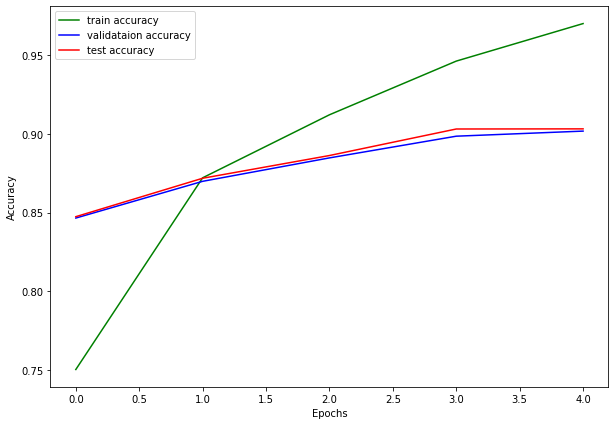

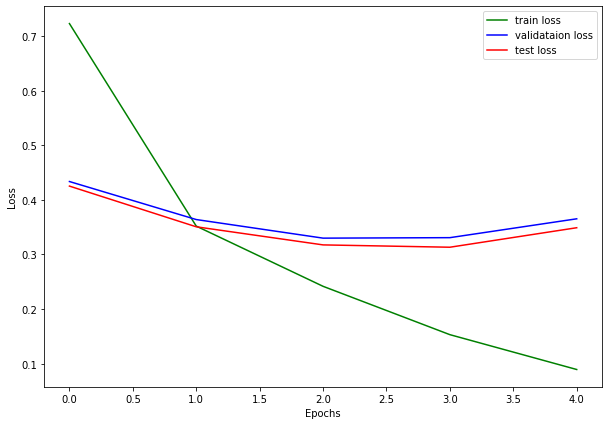

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_acc_set, color='green', label='train accuracy')
plt.plot(valid_acc_set, color='blue', label='validataion accuracy')
plt.plot(test_acc_set, color='red', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss_set, color='green', label='train loss')
plt.plot(valid_loss_set, color='blue', label='validataion loss')
plt.plot(test_loss_set, color='red', label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notes:
- Test accuracy **should not** be higher than train since the model is optimized for training
-  Much higher validation loss than training loss, then it's a sign that your model is overfitting 
  - Over-fitting occurs where you do not employ a **regularization**, you have a very complex model (the number of free parameters W is large) or the number of data points N is very low.
- Loss is often used in the training process to find the "best" parameter values for your model (


In [ ]:
#load weights
path='/content/drive/My Drive/colab_data/attnbilstm/drugs_saved_weights_dataloader.pt'

model.load_state_dict(torch.load(path));
model.to(device);
model.eval();

def predict(model, sentence):
    tokenized = word_tokenize(sentence)
    indexed = [word2idx[w] if w in word2idx else word2idx['UNK'] for w in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor 
    tensor = tensor.unsqueeze(0)                         #reshape in form of no. of words,batch (forward will transpose to batch, no.of words)
    
    length_tensor = torch.LongTensor(length)                  #convert to tensor
    prediction, _ = model(tensor, length_tensor)                  #prediction 
    
    probs = torch.softmax(prediction, dim=1)
    print(probs)
    prediction_ = probs.argmax(dim=1)
    return prediction_
    

In [ ]:
for t in test_dataloader:
  t_seq, t_len, t_lab = t
  print(t_seq)
  print(t_len)
  print(t_lab)
  break

tensor([[59085, 57212, 63590,  ..., 64761, 69256, 88221],
        [59085, 25854, 86247,  ..., 88221,     0,     0],
        [59085, 14520, 49860,  ...,     0,     0,     0],
        ...,
        [59085,  4581, 40751,  ...,     0,     0,     0],
        [59085, 37951, 90225,  ...,     0,     0,     0],
        [59085, 42050, 40751,  ...,     0,     0,     0]])
tensor([174, 172, 171, 170, 168, 167, 167, 166, 165, 164, 163, 160, 157, 155,
        155, 154, 153, 152, 148, 146, 144, 143, 142, 137, 133, 121, 120, 117,
        110, 102, 100,  99,  99,  97,  97,  96,  95,  95,  92,  92,  85,  79,
         79,  78,  77,  72,  72,  71,  65,  64,  63,  61,  58,  56,  49,  48,
         42,  41,  40,  30,  26,  21,  11,   7])
tensor([1, 1, 1, 0, 0, 5, 1, 4, 0, 4, 0, 0, 0, 0, 7, 1, 0, 6, 0, 1, 2, 0, 9, 0,
        2, 5, 0, 0, 4, 8, 0, 3, 0, 4, 0, 1, 7, 0, 1, 5, 0, 1, 9, 9, 3, 0, 8, 8,
        0, 2, 0, 2, 0, 2, 6, 0, 0, 2, 6, 7, 5, 5, 7, 3])


In [ ]:
# make predictions
predict(model, "this is the absolute worst birth control and i wouldnt recommend it to anyone. i have heard so many horror stories about this birth control")

tensor([[9.3871e-01, 5.0379e-08, 4.2832e-07, 1.1484e-08, 6.1285e-02, 2.9866e-07,
         1.8757e-08, 1.7039e-08, 2.9490e-08, 7.2488e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


tensor([0], device='cuda:0')

In [ ]:
print(label_dict[test_df['condition'].iloc[200]])
test_df['review'].iloc[200]

0


'"this is the absolute worst birth control and i wouldnt recommend it to anyone. when i first had it placed i had my period for 5 months straight. now ive had it for almost 2 years (ive procrastinated getting it out) my periods can last from 15-30 days, easy. and im lucky if i get 10 days inbetween them. aside from that, my arm aches and throbs. i have heard so many horror stories about this birth control &amp; plan on getting it taken out soon. ladies, #saynotonexplannon"'